In [2]:
import pandas as pd
import os
import json
# !pip install pywer
import pywer
# !pip install pyjarowinkler
from pyjarowinkler import distance as jwdistance
from tqdm import tqdm

class Const:
    OCR = 'ocr'
    GROUND = 'groundtruth'
    REGION = 'region'
    LINE = 'line'
    SENTENCE = 'sentence'
    FILE = 'filename'
    DATASET = 'dataset_name'
    PREDICTION = 'prediction'
    PROMPT = 'prompt'
    LANGUAGE = 'language'
    NONE = None


### Lookup datasets

In [3]:
datasets = []

for root, dirs, files in os.walk('../data/datasets/ocr/converted'):
    for file in files:
        if file.endswith(".jsonl"):
            input_file = os.path.join(root, file)
            if 'sample' not in input_file:
                with open(input_file) as f:
                    lines = f.read().splitlines()
                df_inter = pd.DataFrame(lines)
                df_inter.columns = ['json_element']
                df_inter['json_element'].apply(json.loads)
                df = pd.json_normalize(df_inter['json_element'].apply(json.loads))

                dataset_name = root.split('/')[-1].replace('_', '-')
                print(input_file, dataset_name)
                df['dataset_name'] = [dataset_name] * len(df)
                if 'ajmc' in dataset_name:
                    df['language'] = ['el'] * len(df)
                if 'overproof' in dataset_name:
                    df['language'] = ['en'] * len(df)
                if 'impresso' in dataset_name:
                    df['language'] = ['de'] * len(df)
                    
                datasets.append(df)
            

../data/datasets/ocr/converted/ajmc-mixed/ajmc_mixed.jsonl ajmc-mixed
../data/datasets/ocr/converted/overproof/overproof.jsonl overproof
../data/datasets/ocr/converted/icdar-2019/icdar-2019.jsonl icdar-2019
../data/datasets/ocr/converted/icdar-2017/icdar-2017.jsonl icdar-2017
../data/datasets/ocr/converted/impresso/impresso-nzz.jsonl impresso
../data/datasets/ocr/converted/ajmc-primary/ajmc_primary_text.jsonl ajmc-primary


In [3]:
print('Number of unique lines/sentences/regions.\n')
for dataset in datasets:
    print('Dataset:', dataset['dataset_name'].unique()[0], len(dataset), 'with duplicates')
    print('No. lines:', dataset['ocr.line']. nunique(), '/', len(dataset['ocr.sentence']), 
          'No. sentences:', dataset['ocr.sentence']. nunique(), '/', len(dataset['ocr.sentence']), 
          'No. regions:', dataset['ocr.region']. nunique(), '/', len(dataset['ocr.region']))
    print('-'*80)

Number of unique lines/sentences/regions.

Dataset: ajmc-mixed 2131 with duplicates
No. lines: 870 / 2131 No. sentences: 679 / 2131 No. regions: 63 / 2131
--------------------------------------------------------------------------------
Dataset: overproof 2669 with duplicates
No. lines: 2278 / 2669 No. sentences: 399 / 2669 No. regions: 41 / 2669
--------------------------------------------------------------------------------
Dataset: icdar-2019 404 with duplicates
No. lines: 0 / 404 No. sentences: 404 / 404 No. regions: 41 / 404
--------------------------------------------------------------------------------
Dataset: icdar-2017 477 with duplicates
No. lines: 0 / 477 No. sentences: 461 / 477 No. regions: 28 / 477
--------------------------------------------------------------------------------
Dataset: impresso 1563 with duplicates
No. lines: 1256 / 1563 No. sentences: 577 / 1563 No. regions: 203 / 1563
--------------------------------------------------------------------------------
Data

In [4]:
# GENERATE_SAMPLE = False

# if GENERATE_SAMPLE:
#     from sklearn.model_selection import train_test_split

#     files_keep, files_removed, _, _ = train_test_split(dataset, dataset['dataset_name'], 
#                                                        test_size=0.90, random_state=42)
    
# if GENERATE_SAMPLE:
#     output_file = '../data/datasets/ocr/converted/sample/sample.jsonl'
#     with open(output_file, "w") as outfile:
#         for index, row in files_keep.iterrows():

#             json_line = json.dumps({Const.LANGUAGE: row['language'],
#                                     Const.FILE: row['filename'],
#                                     Const.DATASET: row['dataset_name'],
#                                     Const.OCR: {Const.LINE: row['ocr.line'],
#                                                 Const.SENTENCE: row['ocr.sentence'],
#                                                 Const.REGION: row['ocr.region']}, 
#                                     Const.GROUND: {Const.LINE: row['groundtruth.line'],
#                                                    Const.SENTENCE: row['groundtruth.sentence'],
#                                                    Const.REGION: row['groundtruth.region']},
#                                     'File': row['File'], 
#                                     'Date': row['Date'],
#                                     'Type': row['Type'], 
#                                     'NbAlignedChar': row['NbAlignedChar'], 
#                                     'article_id': row['article_id']
#                                     })

#             outfile.write(json_line + "\n")
#             outfile.flush()
            
            


### Analsys of preliminary results

In [54]:
results = []

for root, dirs, files in os.walk('../data/output'):
    for file in files:
        if file.endswith(".jsonl"):
            input_file = os.path.join(root, file)
            
            if 'sample' not in input_file:
                prompt = root.split('/')[-2]
                with open(input_file) as f:
                    lines = f.read().splitlines()
                try:
                    df_inter = pd.DataFrame(lines)
                    df_inter.columns = ['json_element']

                    dataset_name = root.split('/')[-1].replace('_', '-')
                    model_dataset_name = file[8:-6]
                    model_name = model_dataset_name.replace(root.split('/')[-1] + '-', '').strip()
                    
                    df_inter['json_element'].apply(json.loads)
                    df = pd.json_normalize(df_inter['json_element'].apply(json.loads))
                    
                    df['model'] = [model_name] * len(df)
                    
                    df['dataset_name'] = [dataset_name] * len(df)
                    df['prompt'] = [prompt] * len(df)
                    
                    print(root.split('/')[-1], dataset_name, model_name, prompt)
#                     print(model_name)
                    results.append(df)
                except:
                    print('We could not load {}'.format(file))
                    

overproof overproof gpt-4 prompt_basic_02
overproof overproof gpt-3.5-turbo prompt_basic_02
overproof overproof facebook-opt-350m prompt_basic_02
We could not load results-overproof-decapoda-research-llama-7b-hf.jsonl
overproof overproof bigscience-bloom-560m prompt_basic_02
htrec htrec bigscience-bloom-560m prompt_basic_02
htrec htrec facebook-opt-350m prompt_basic_02
htrec htrec decapoda-research-llama-7b-hf prompt_basic_02
ajmc_mixed ajmc-mixed decapoda-research-llama-7b-hf prompt_basic_02
ajmc_mixed ajmc-mixed bigscience-bloom-560m prompt_basic_02
ajmc_mixed ajmc-mixed facebook-opt-350m prompt_basic_02
ajmc_mixed ajmc-mixed gpt-4 prompt_basic_02
icdar-2019 icdar-2019 bigscience-bloom-560m prompt_basic_02
icdar-2019 icdar-2019 decapoda-research-llama-7b-hf prompt_basic_02
icdar-2019 icdar-2019 facebook-opt-350m prompt_basic_02
icdar-2019 icdar-2019 gpt-4 prompt_basic_02
icdar-2019 icdar-2019 gpt-3.5-turbo prompt_basic_02
icdar-2017 icdar-2017 bigscience-bloom-560m prompt_basic_02
ic

In [5]:
len(results)

99

In [6]:
results[0].head()

,filename,dataset_name,article_id,ocr.line,ocr.sentence,ocr.region,groundtruth.line,groundtruth.sentence,groundtruth.region,prediction.prompt,prediction.line,prediction.sentence,prediction.region,model,prompt
0,../../data/datasets/ocr/original/overproof/dat...,overproof,7 year 1922 type Article title http://chronicl...,RAIDERS IN,"RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...","RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...",RAIDERS IN,"RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...","RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...",Correct the spelling and grammar of the follow...,Raiders Inc.,"Raiders in Frederick Land Haul of $84,000: Wat...","Raiders in Frederick Land Haul of $84,000\n\nW...",gpt-4,prompt_basic_02
1,../../data/datasets/ocr/original/overproof/dat...,overproof,7 year 1922 type Article title http://chronicl...,FREDERICK,"RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...","RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...",FREDER IC K,"RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...","RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...",Correct the spelling and grammar of the follow...,Frederick,"Raiders in Frederick Land Haul of $84,000: Wat...","Raiders in Frederick Land Haul of $84,000\n\nW...",gpt-4,prompt_basic_02
2,../../data/datasets/ocr/original/overproof/dat...,overproof,7 year 1922 type Article title http://chronicl...,LAND HAUL,"RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...","RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...",LAND HAUL,"RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...","RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...",Correct the spelling and grammar of the follow...,Land Haul,"Raiders in Frederick Land Haul of $84,000: Wat...","Raiders in Frederick Land Haul of $84,000\n\nW...",gpt-4,prompt_basic_02
3,../../data/datasets/ocr/original/overproof/dat...,overproof,7 year 1922 type Article title http://chronicl...,"OF $84,000","RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...","RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...","OF $84,000","RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...","RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...",Correct the spelling and grammar of the follow...,"Of $84,000","Raiders in Frederick Land Haul of $84,000: Wat...","Raiders in Frederick Land Haul of $84,000\n\nW...",gpt-4,prompt_basic_02
4,../../data/datasets/ocr/original/overproof/dat...,overproof,7 year 1922 type Article title http://chronicl...,Watchman Bound and Gagged,"RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...","RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...",Watchman Bound and Gagged,"RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...","RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...",Correct the spelling and grammar of the follow...,Watchman Bound and Gagged,"Raiders in Frederick Land Haul of $84,000: Wat...","Raiders in Frederick Land Haul of $84,000\n\nW...",gpt-4,prompt_basic_02


In [7]:
data = pd.concat(results)
data.head()


,filename,dataset_name,article_id,ocr.line,ocr.sentence,ocr.region,groundtruth.line,groundtruth.sentence,groundtruth.region,prediction.prompt,...,prediction.sentence,prediction.region,model,prompt,century,language,File,Date,Type,NbAlignedChar
0,../../data/datasets/ocr/original/overproof/dat...,overproof,7 year 1922 type Article title http://chronicl...,RAIDERS IN,"RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...","RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...",RAIDERS IN,"RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...","RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...",Correct the spelling and grammar of the follow...,...,"Raiders in Frederick Land Haul of $84,000: Wat...","Raiders in Frederick Land Haul of $84,000\n\nW...",gpt-4,prompt_basic_02,NaN,NaN,NaN,NaN,NaN,NaN
1,../../data/datasets/ocr/original/overproof/dat...,overproof,7 year 1922 type Article title http://chronicl...,FREDERICK,"RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...","RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...",FREDER IC K,"RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...","RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...",Correct the spelling and grammar of the follow...,...,"Raiders in Frederick Land Haul of $84,000: Wat...","Raiders in Frederick Land Haul of $84,000\n\nW...",gpt-4,prompt_basic_02,NaN,NaN,NaN,NaN,NaN,NaN
2,../../data/datasets/ocr/original/overproof/dat...,overproof,7 year 1922 type Article title http://chronicl...,LAND HAUL,"RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...","RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...",LAND HAUL,"RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...","RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...",Correct the spelling and grammar of the follow...,...,"Raiders in Frederick Land Haul of $84,000: Wat...","Raiders in Frederick Land Haul of $84,000\n\nW...",gpt-4,prompt_basic_02,NaN,NaN,NaN,NaN,NaN,NaN
3,../../data/datasets/ocr/original/overproof/dat...,overproof,7 year 1922 type Article title http://chronicl...,"OF $84,000","RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...","RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...","OF $84,000","RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...","RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...",Correct the spelling and grammar of the follow...,...,"Raiders in Frederick Land Haul of $84,000: Wat...","Raiders in Frederick Land Haul of $84,000\n\nW...",gpt-4,prompt_basic_02,NaN,NaN,NaN,NaN,NaN,NaN
4,../../data/datasets/ocr/original/overproof/dat...,overproof,7 year 1922 type Article title http://chronicl...,Watchman Bound and Gagged,"RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...","RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...",Watchman Bound and Gagged,"RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...","RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...",Correct the spelling and grammar of the follow...,...,"Raiders in Frederick Land Haul of $84,000: Wat...","Raiders in Frederick Land Haul of $84,000\n\nW...",gpt-4,prompt_basic_02,NaN,NaN,NaN,NaN,NaN,NaN


## Post-process

In [24]:
import Levenshtein
from Levenshtein import distance

def compute_normalized_levenshtein_similarity(ocr_text, ground_truth_text):
    length = max(len(ocr_text), len(ground_truth_text))
    levenshtein_distance = distance(ocr_text, ground_truth_text)
    similarity = (length - levenshtein_distance) / length
    return similarity

def compute_jaccard(ocr_text, ground_truth_text):
    try: 
        return jwdistance.get_jaro_distance(ocr_text, ground_truth_text)
    except:
        return 0.0

# def get_improvement(original_distance, corrected_distance):
#     return 1.0 - (original_distance - corrected_distance)

def get_improvement(original_similarity, corrected_similarity):
    if corrected_similarity != 0:
        return (corrected_similarity - original_similarity) / corrected_similarity
    else:
        return corrected_similarity - original_similarity

In [9]:
data.tail()


,filename,dataset_name,article_id,ocr.line,ocr.sentence,ocr.region,groundtruth.line,groundtruth.sentence,groundtruth.region,prediction.prompt,...,prediction.sentence,prediction.region,model,prompt,century,language,File,Date,Type,NbAlignedChar
325,Wecklein1894,ajmc-primary-text,NaN,"ὅπου δ’ ὑβρίζειν δρᾶν θ’ ἃ βούλεται παρῇ,","δέος γὰρ πρόσεστιν αἰσχύνη W ὁμοῦ, σωτηρίαν ἔχ...",μηδὲν φόβου πρόβλημα und αἰδοῦς ἔχων. ἀλλ’ ἄνδ...,"ὅπου δ’ ὑβρίζειν δρᾶν θ’ ἃ βούλεται παρῇ,","δέος γὰρ ᾧ πρόσεστιν αἰσχύνη θ’ ὁμοῦ, σωτηρίαν...",μηδὲν φόβου πρόβλημα μηδ’ αἰδοῦς ἔχων. ἀλλ’ ἄν...,"Correct the text: ""δέος γὰρ πρόσεστιν αἰσχύνη ...",...,There are no errors in this text. Here is the ...,No changes are needed as this appears to be a ...,gpt-3.5-turbo,prompt_basic_01,NaN,NaN,NaN,NaN,NaN,NaN
326,Wecklein1894,ajmc-primary-text,NaN,ταύτην νόμιζε τὴν πόλιν χρόνῳ ποτὲ,"δέος γὰρ πρόσεστιν αἰσχύνη W ὁμοῦ, σωτηρίαν ἔχ...",μηδὲν φόβου πρόβλημα und αἰδοῦς ἔχων. ἀλλ’ ἄνδ...,ταύτην νόμιζε τὴν πόλιν χρόνῳ ποτὲ,"δέος γὰρ ᾧ πρόσεστιν αἰσχύνη θ’ ὁμοῦ, σωτηρίαν...",μηδὲν φόβου πρόβλημα μηδ’ αἰδοῦς ἔχων. ἀλλ’ ἄν...,"Correct the text: ""ταύτην νόμιζε τὴν πόλιν χρό...",...,There are no errors in this text. Here is the ...,No changes are needed as this appears to be a ...,gpt-3.5-turbo,prompt_basic_01,NaN,NaN,NaN,NaN,NaN,NaN
327,Wecklein1894,ajmc-primary-text,NaN,ἐξ οὐρίων δραμοῦσαν ἐς βυθὸν πεσεῖν.,"δέος γὰρ πρόσεστιν αἰσχύνη W ὁμοῦ, σωτηρίαν ἔχ...",μηδὲν φόβου πρόβλημα und αἰδοῦς ἔχων. ἀλλ’ ἄνδ...,ἐξ οὐρίων δραμοῦσαν ἐς βυθὸν πεσεῖν.,"δέος γὰρ ᾧ πρόσεστιν αἰσχύνη θ’ ὁμοῦ, σωτηρίαν...",μηδὲν φόβου πρόβλημα μηδ’ αἰδοῦς ἔχων. ἀλλ’ ἄν...,"Correct the text: ""ἐξ οὐρίων δραμοῦσαν ἐς βυθὸ...",...,There are no errors in this text. Here is the ...,No changes are needed as this appears to be a ...,gpt-3.5-turbo,prompt_basic_01,NaN,NaN,NaN,NaN,NaN,NaN
328,Wecklein1894,ajmc-primary-text,NaN,"ΧΟ. Μενέλαε, μὴ γνώμας ὑποστήσας σοφὰς",ΧΟ.,μηδὲν φόβου πρόβλημα und αἰδοῦς ἔχων. ἀλλ’ ἄνδ...,"ΧΟ. Μενέλαε, un γνώμας ὑποστήσας σοφὰς",ΧΟ.,μηδὲν φόβου πρόβλημα μηδ’ αἰδοῦς ἔχων. ἀλλ’ ἄν...,"Correct the text: ""ΧΟ. Μενέλαε, μὴ γνώμας ὑποσ...",...,"I'm sorry but ""ΧΟ.""",No changes are needed as this appears to be a ...,gpt-3.5-turbo,prompt_basic_01,NaN,NaN,NaN,NaN,NaN,NaN
329,Wecklein1894,ajmc-primary-text,NaN,"ΧΟ. Μενέλαε, μὴ γνώμας ὑποστήσας σοφὰς",ΧΟ.,μηδὲν φόβου πρόβλημα und αἰδοῦς ἔχων. ἀλλ’ ἄνδ...,"ΧΟ. Μενέλαε, un γνώμας ὑποστήσας σοφὰς",ΧΟ.,μηδὲν φόβου πρόβλημα μηδ’ αἰδοῦς ἔχων. ἀλλ’ ἄν...,NaN,...,"I'm sorry but ""ΧΟ.""",No changes are needed as this appears to be a ...,gpt-3.5-turbo,prompt_basic_01,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
gt_text = "149 Obrázek z maloměstského kukátka. Podává L. Gro"
ocr_text = "149 Obrázek z maloměstského kukátka. Podává L. Grw"
pred_text = """Correct the text: "149 Obrázek z maloměstského kukátka. Podává L. Grwsmannová-Brodská. Místo děje: salon paní stavitelky; doba: čas věnovaný kávové „visitě"; jednající osoby: dámy přednější honorace městské, z nichž •většina je mladá a některé skutečně hezké. Na stole prostřeném krásným ubrusem damaškovým stojí talíře s koláčky, věnečky a preclíčky, kol toho pěkně se vyjímají křišťálové sklenky s vodou, stříbrné lžičky a šálky z jemného porcelánu, jejichž vonný obsah na přítomné paničky zdá se velmi blaze působiti. Ze živějšího hovoru vyznívá právě hlas paní notářky, která ve spravedlivém rozhorlení mluví: „Ano, mé dámy, již jest to takové! Samy ráčily jste býti svědky, jak svorně i jednohlasně byl přijat návrh paní sládkové, abychom si pořídily kroje národní a tak přispěly ku zvýšení lesku slavnosti, již pořádá náš statečný studentský spolek „Hvězda", a když již nás páni akademikové poctili důvěrou, že v naše ruce složili starost o buffet a jiné ještě funkce, tož měly bychom snad též jiti za příkladem slečen berních a vzdáti se činnosti jen proto, že se zdá paní berní národní kroj pro tři dcery býti nějakou zby tečnou výlohou?" Paničky projevovaly svoji nevoli, každá jiným spůsobem. Mladá paní adjunktová v duchu si umiňovala, že ve svém přátel ství k berňovům trochu ochladne; to tak! aby ten jejich pošetilý nápad, úóinkovati při slavnosti v obyčejném oděvu, přece zvítězil a dámám se bylo odříci těch půvabných krojů venkovských, co by si jen ona, paní adjunktová, počala s tou haldou brokátu, atlasu, krajek, stuh a aksamitu, za což vydala nejednu desítku, utěšujíc se tím, jak jí to bude slušeti! Hm, a škodu z toho také míti nebude, muž se bude musit po několik měsíců uskrovnit, služka se má beztoho též až příliš dobře, uhradí se to na domácnosti a bude! Nyní ujala se slova paní doktorka: „Aj, od berních to není nic divného, považte jen: tolik dětí! Vždyť my všecky víme, že kdyby sobě slečny toillety samy ne řídily, mnohého by nemohly míti; ony pak mají zásadu: nemá-li být něco pěkné, tož raději nic!" „Pravda, ale slečny Elišky, té nejmladší, jest mně líto; těšila se velice na selský kroj." „Ba ano, byla by v něm vypadala roztomile." „Nyní má po radosti." „Inu, proč má tak nepřející matinku." „To není to, má drahá, jest v tom však jiný háček." „Ah, ano; vždyť víme, že sotva tak tak vyjdou." „Ale na knihy, které jsi tvá, jinak našel byste jen krytí těch mladých mozí, jinak je vydáte." „A tak bude, ostatně jdu až na knihy; ale slyšet jsem od někoho, že o krojech něco dělat, a že to bylo bude dělat národní, a když jsi tento národní učil jak, pak by měl nalézt tuto kartu, ta by se jistě mohla vyměnit se všemi. Můžete-li to od nás odkázat?" Všem ozdravila její hlas, když řekla: „Já, já! a já ho učím. S těmi páne akademiky jsem již mohla vyprávět o světě, v němž vznítí v některé nocy a jednoho dne vyrostá vám hrozný kouzelný strom zůstane, o němž je psáno: ‚Už jen žádat!" 50 V tuto chvíli koupili mohou-li všichni pánové i paní, že když jsi to čerpala, dá se jen kupit. Přižili to, a já jim vám koupi ukáži.
„A já už jste tím vyděštila. Pánové, děkuji vám za chytré vědomí, se kterým vám projeví, že se už točí dívčí zrcadlo." – 151"""
                
get_improvement(compute_normalized_levenshtein_similarity(gt_text, ocr_text), 
                compute_normalized_levenshtein_similarity(gt_text, pred_text))




-61.2692

In [43]:
def get_improvement(old_value, new_value):
    if old_value == 0:
        if new_value == 0:
            return 0
        else:
            return 0 # np.inf  # or return a large number or handle as needed
    else:
        improvement = (new_value - old_value) / old_value * 100
        return improvement

In [44]:
gt_text = 'testing'
ocr_text = 'resting'
pred_text = 'testing'

compute_normalized_levenshtein_similarity(gt_text, ocr_text), distance(gt_text, ocr_text)

(0.8571428571428571, 1)

In [16]:
get_improvement(compute_normalized_levenshtein_similarity(gt_text, ocr_text), 
                compute_normalized_levenshtein_similarity(gt_text, pred_text))


0.1428571428571429

In [23]:
import Levenshtein

# Example strings
s1 = "testing"
s2 = "resting"

# Calculate the Levenshtein distance
lev_distance = Levenshtein.distance(s1, s2)
print(f"Levenshtein distance: {distance}")

# Calculate the Levenshtein similarity
similarity = (max(len(s1), len(s2)) - lev_distance) / max(len(s1), len(s2))
print(f"Levenshtein similarity: {similarity:.2f}")


Levenshtein distance: 1
Levenshtein similarity: 0.86


In [18]:
def postprocess(text):
    if text is not None:
        if len(text.strip()) > 0:
            if text.startswith('"'):
                text = text[1:]
            if text.endswith('"'):
                text = text[:-1]
    return text

In [20]:
data = pd.concat(results)

data['model'].unique()

array(['gpt-4', 'gpt-3.5-turbo', 'facebook-opt-350m',
       'bigscience-bloom-560m', 'decapoda-research-llama-7b-hf',
       'davinci', 'gpt2', 'tloen-alpaca-lora-7b'], dtype=object)

In [105]:
# Define OCR noise level bins
# bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
bins = [0, 0.7, 0.8, 0.9, 1]

# Assign OCR noise level labels
# labels = ["0-10%", "10-20%", "20-30%", "30-40%", "40-50%", "50-60%", "60-70%", "70-80%", "80-90%", "90-100%"]
labels = ["0-70%", "70-80%", "80-90%", "90-100%"]


for idx, result in tqdm(enumerate(results), total=len(results)):
    
    try:
        results[idx] = results[idx].fillna('No text')
    except:
        pass
#     results[idx] = results[idx][results[idx].model != 'tloen-alpaca-lora-7b']
    
    dataset_name = results[idx]['dataset_name'].unique()[0]
    model_name = results[idx]['model'].unique()[0]
    prompt = results[idx]['prompt'].unique()[0]
    
#     print('Dataset:', dataset_name, 'Model:', model_name, 'Prompt:', prompt)
    
    if 'alpaca' not in model_name:
    
        if 'icdar' in dataset_name:
            text_types = ['sentence', 'region']
        else:
            text_types = ['line', 'sentence', 'region']
        for segment_type in text_types:

            results[idx]['length'] = results[idx][f'groundtruth.{segment_type}'].str.len()
            results[idx] = results[idx][results[idx]['length'] > 3]

            results[idx][f'prediction.{segment_type}'] = results[idx][f'prediction.{segment_type}'].apply(postprocess)
            
#             # Compute Jaccard similarity
#             results[idx][f'{segment_type}-jaccard-ocr'] = \
#                 results[idx].apply(lambda x: compute_jaccard(x[f'groundtruth.{segment_type}'],
#                                                              x[f'ocr.{segment_type}']), axis=1)
            
#             results[idx][f'{segment_type}-jaccard-pred'] = \
#                 results[idx].apply(lambda x: compute_jaccard(x[f'groundtruth.{segment_type}'],
#                                                              x[f'prediction.{segment_type}']), axis=1)
            
            # Compute Lev similarity
            results[idx][f'{segment_type}-lev-ocr'] = \
                results[idx].apply(lambda x: compute_normalized_levenshtein_similarity(x[f'groundtruth.{segment_type}'],
                                                                                     x[f'ocr.{segment_type}']), axis=1)
            results[idx][f'{segment_type}-lev-pred'] = \
                results[idx].apply(lambda x: compute_normalized_levenshtein_similarity(x[f'groundtruth.{segment_type}'],
                                                                                     x[f'prediction.{segment_type}']), axis=1)

            results[idx][f'{segment_type}-lev-improvement'] = \
                results[idx].apply(lambda x: get_improvement(x[f'{segment_type}-lev-ocr'],
                                                             x[f'{segment_type}-lev-pred']), axis=1)
            # Compute CER
            results[idx][f'{segment_type}-cer-ocr'] = results[idx].apply(lambda x: pywer.cer(x[f'ocr.{segment_type}'], 
                                                                                             x[f'groundtruth.{segment_type}']), axis=1)
            results[idx][f'{segment_type}-cer-pred'] = results[idx].apply(lambda x: pywer.cer(x[f'prediction.{segment_type}'], 
                                                                                              x[f'groundtruth.{segment_type}']), axis=1)

            # Compute WER
            results[idx][f'{segment_type}-wer-ocr'] = results[idx].apply(lambda x: pywer.wer(x[f'ocr.{segment_type}'], 
                                                                                             x[f'groundtruth.{segment_type}']), axis=1)
            results[idx][f'{segment_type}-wer-pred'] = results[idx].apply(lambda x: pywer.wer(x[f'prediction.{segment_type}'], 
                                                         x[f'groundtruth.{segment_type}']), axis=1)

            # CER & WER improvement
            results[idx][f'{segment_type}-cer-improvement'] = \
                results[idx].apply(lambda x: get_improvement(x[f'{segment_type}-cer-ocr'],
                                                             x[f'{segment_type}-cer-pred']), axis=1)
            results[idx][f'{segment_type}-wer-improvement'] = \
                results[idx].apply(lambda x: get_improvement(x[f'{segment_type}-wer-ocr'],
                                                             x[f'{segment_type}-wer-pred']), axis=1)

            # Create a new column for the OCR noise level bins
            results[idx][f"{segment_type}-ocr-noise-group"] = pd.cut(results[idx][f'{segment_type}-lev-ocr'], 
                                                     bins=bins, labels=labels, 
                                                     include_lowest=True)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [09:05<00:00,  5.51s/it]


In [56]:
data = pd.concat(results)



In [104]:
data.head()

,filename,dataset_name,article_id,ocr.line,ocr.sentence,ocr.region,groundtruth.line,groundtruth.sentence,groundtruth.region,prediction.prompt,...,region-wer-pred,region-cer-improvement,region-wer-improvement,region-ocr-noise-group,century,language,File,Date,Type,NbAlignedChar
1559,../../data/datasets/ocr/original/overproof/dat...,overproof,17431000 year 1938 type Article title The Sydn...,GREAT SPECTACLE.,GREAT SPECTACLE.,"PAGEANT OF NATIONS."" GREAT SPECTACLE. Magnific...",GREAT SPECTACLE.,GREAT SPECTACLE.,"""PAGEANT OF NATIONS."" GREAT SPECTACLE. Magnifi...",Correct the spelling and grammar of the follow...,...,111.671924,-0.162825,-0.350897,90-100%,NaN,NaN,NaN,NaN,NaN,NaN
1560,../../data/datasets/ocr/original/overproof/dat...,overproof,17431000 year 1938 type Article title The Sydn...,Magnificent Scenes.,Magnificent Scenes.,"PAGEANT OF NATIONS."" GREAT SPECTACLE. Magnific...",Magnificent Scenes.,Magnificent Scenes.,"""PAGEANT OF NATIONS."" GREAT SPECTACLE. Magnifi...",Correct the spelling and grammar of the follow...,...,111.671924,-0.162825,-0.350897,90-100%,NaN,NaN,NaN,NaN,NaN,NaN
1568,../../data/datasets/ocr/original/overproof/dat...,overproof,17431000 year 1938 type Article title The Sydn...,something of a feast both for the eye and the,"Full of glittering colour, the pageant is some...","PAGEANT OF NATIONS."" GREAT SPECTACLE. Magnific...",something of a feast both for the eye and the,"Full of glittering colour, the pagennt is some...","""PAGEANT OF NATIONS."" GREAT SPECTACLE. Magnifi...",Correct the spelling and grammar of the follow...,...,111.671924,-0.162825,-0.350897,90-100%,NaN,NaN,NaN,NaN,NaN,NaN
1569,../../data/datasets/ocr/original/overproof/dat...,overproof,17431000 year 1938 type Article title The Sydn...,"car, in its brilliant national settings,","Full of glittering colour, the pageant is some...","PAGEANT OF NATIONS."" GREAT SPECTACLE. Magnific...","car, in its brilliant national settings,","Full of glittering colour, the pagennt is some...","""PAGEANT OF NATIONS."" GREAT SPECTACLE. Magnifi...",Correct the spelling and grammar of the follow...,...,111.671924,-0.162825,-0.350897,90-100%,NaN,NaN,NaN,NaN,NaN,NaN
1570,../../data/datasets/ocr/original/overproof/dat...,overproof,17431000 year 1938 type Article title The Sydn...,"ensembles, and dances, and in its sparkling","Full of glittering colour, the pageant is some...","PAGEANT OF NATIONS."" GREAT SPECTACLE. Magnific...","ensembles, and dances, and in its sparkling","Full of glittering colour, the pagennt is some...","""PAGEANT OF NATIONS."" GREAT SPECTACLE. Magnifi...",Correct the spelling and grammar of the follow...,...,111.671924,-0.162825,-0.350897,90-100%,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
data.length
len(data)


72684

In [101]:
data = data[data['region-lev-ocr'] > 0.99]
len(data)

4693

In [102]:
data = data[data['line-lev-ocr'] > 0.99]
len(data)

2372

In [103]:
data = data[data['sentence-lev-ocr'] > 0.99]
len(data)

2012

In [58]:
data.columns

Index(['filename', 'dataset_name', 'article_id', 'ocr.line', 'ocr.sentence',
       'ocr.region', 'groundtruth.line', 'groundtruth.sentence',
       'groundtruth.region', 'prediction.prompt', 'prediction.line',
       'prediction.sentence', 'prediction.region', 'model', 'prompt', 'length',
       'line-lev-ocr', 'line-lev-pred', 'line-lev-improvement', 'line-cer-ocr',
       'line-cer-pred', 'line-wer-ocr', 'line-wer-pred',
       'line-cer-improvement', 'line-wer-improvement', 'line-ocr-noise-group',
       'sentence-lev-ocr', 'sentence-lev-pred', 'sentence-lev-improvement',
       'sentence-cer-ocr', 'sentence-cer-pred', 'sentence-wer-ocr',
       'sentence-wer-pred', 'sentence-cer-improvement',
       'sentence-wer-improvement', 'sentence-ocr-noise-group',
       'region-lev-ocr', 'region-lev-pred', 'region-lev-improvement',
       'region-cer-ocr', 'region-cer-pred', 'region-wer-ocr',
       'region-wer-pred', 'region-cer-improvement', 'region-wer-improvement',
       'region-ocr-n

In [59]:
data['model'].unique()

array(['gpt-4', 'gpt-3.5-turbo', 'facebook-opt-350m',
       'bigscience-bloom-560m', 'decapoda-research-llama-7b-hf',
       'davinci', 'gpt2', 'tloen-alpaca-lora-7b'], dtype=object)

In [75]:
data['dataset_name'].unique()

array(['overproof', 'htrec', 'ajmc-mixed', 'icdar-2019', 'icdar-2017',
       'ajmc-primary-text', 'impresso-nzz'], dtype=object)

In [76]:
for x in data['region-lev-improvement'].unique():
    if x > 100.0: 
        print(x)

114.28571428571426


In [96]:
data[data['region-lev-improvement'] > 110.0]['region-lev-ocr']

14    0.1
15    0.1
Name: region-lev-ocr, dtype: float64

In [85]:
data[data['region-lev-improvement'] > 110.0]['groundtruth.region']

14    Neue Zürcher-Zeitung
15    Neue Zürcher-Zeitung
Name: groundtruth.region, dtype: object

In [81]:
data[data['region-lev-improvement'] > 110.0]['ocr.region']

14    stelle
15    stelle
Name: ocr.region, dtype: object

In [83]:
data[data['region-lev-improvement'] > 110.0]['prediction.region']

14    I cannot correct the text without context,
15    I cannot correct the text without context,
Name: prediction.region, dtype: object

In [88]:
data[data['region-lev-improvement'] > 110.0]['ocr.region'].iloc[0]

'stelle'

In [93]:
compute_normalized_levenshtein_similarity(data[data['region-lev-improvement'] > 110.0]['groundtruth.region'].iloc[0], 
                                         data[data['region-lev-improvement'] > 110.0]['ocr.region'].iloc[0])




0.1

In [94]:
compute_normalized_levenshtein_similarity(data[data['region-lev-improvement'] > 110.0]['groundtruth.region'].iloc[0], 
                                         data[data['region-lev-improvement'] > 110.0]['prediction.region'].iloc[0])



0.21428571428571427

In [91]:
get_improvement(compute_normalized_levenshtein_similarity(
                                         data[data['region-lev-improvement'] > 110.0]['groundtruth.region'].iloc[0], 
                                         data[data['region-lev-improvement'] > 110.0]['ocr.region'].iloc[0]),
                compute_normalized_levenshtein_similarity(data[data['region-lev-improvement'] > 110.0]['groundtruth.region'].iloc[0], 
                                         data[data['region-lev-improvement'] > 110.0]['prediction.region'].iloc[0])

)



114.28571428571426

### Distribution of WER/CER rates for all datasets in the four quality bands, established via Levenshtein similarity.

In [51]:
data.dataset_name.unique()

array(['overproof', 'htrec', 'ajmc-mixed', 'icdar-2019', 'icdar-2017',
       'ajmc-primary-text', 'impresso-nzz'], dtype=object)

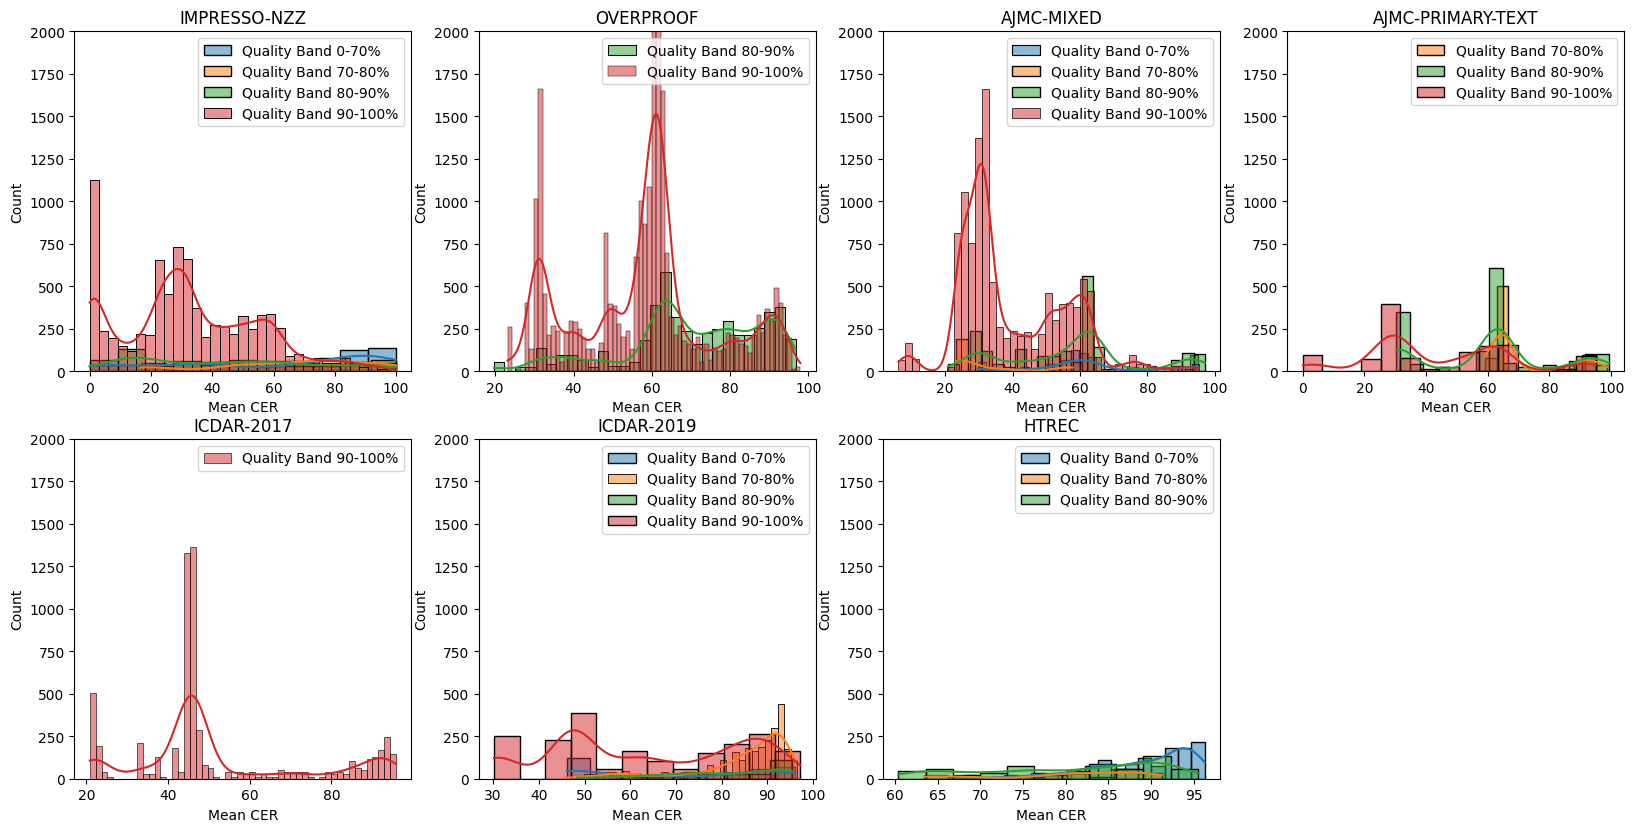

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

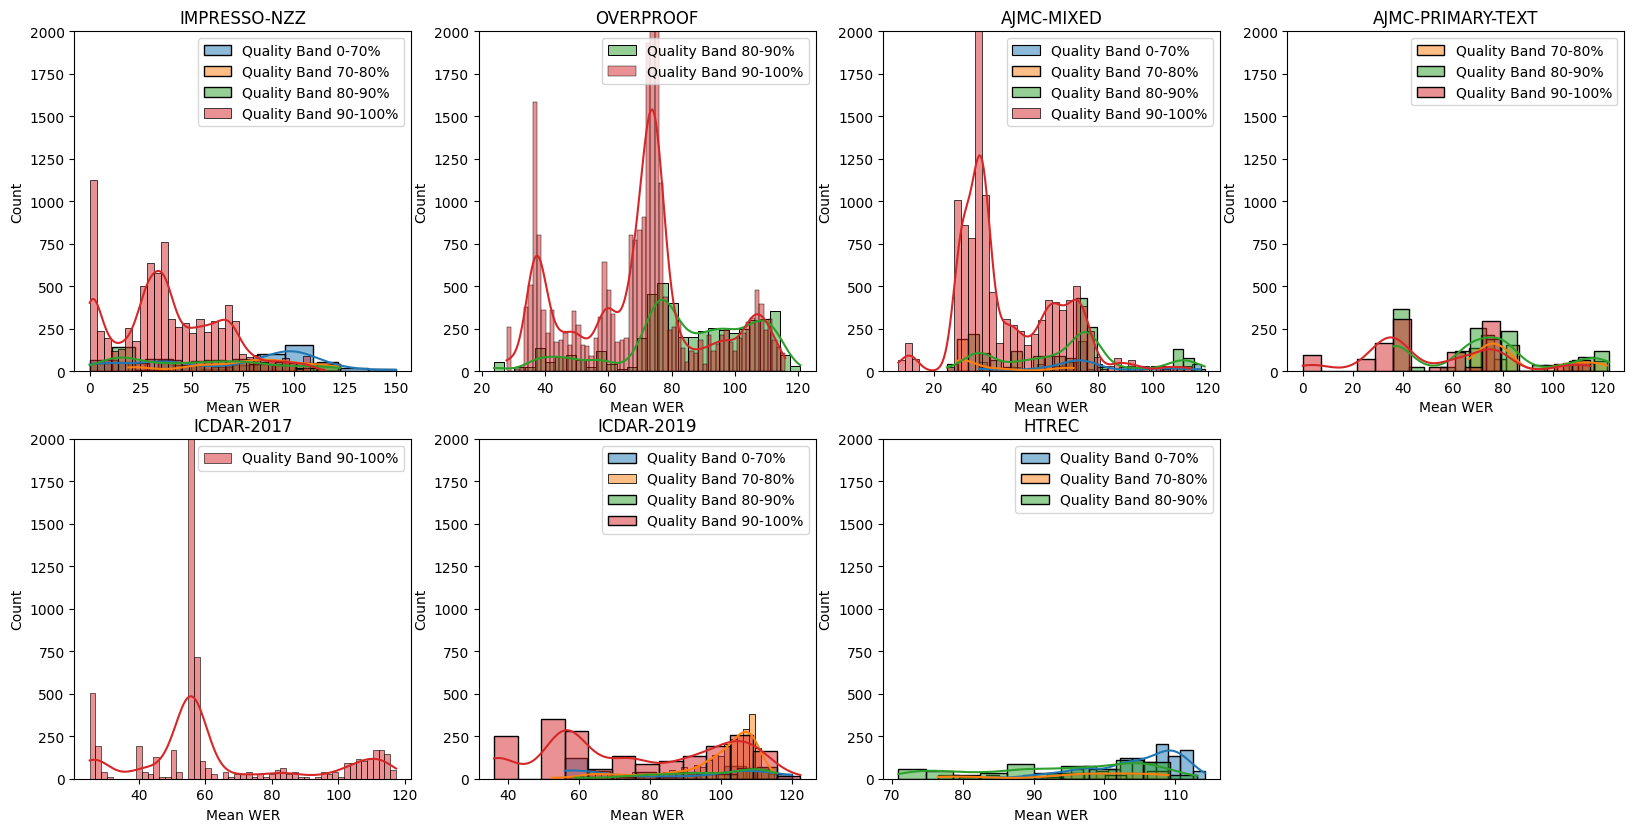

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Define the bins and labels for quality bands
bins = [0, 0.7, 0.8, 0.9, 1]
labels = ["0-70%", "70-80%", "80-90%", "90-100%"]

# Count the number of unique datasets
n_datasets = data.dataset_name.nunique()
dataset_names = ['impresso-nzz', 'overproof', 'ajmc-mixed', 
                 'ajmc-primary-text', 'icdar-2017', 'icdar-2019', 'htrec']

for error_rate in ['cer', 'wer']:
    # Create subplots
    fig, axs = plt.subplots(3, 4, figsize=(20, 15))

    # Flatten the axes for easy iteration
    axs = axs.flatten()

    for i, dataset in enumerate(dataset_names):
        dataset_data = data[data.dataset_name == dataset]

        # Compute the mean WER across line, sentence, and region levels
        dataset_data[f'Mean {error_rate.upper()}'] = dataset_data[[f'line-{error_rate}-ocr', 
                                                 f'sentence-{error_rate}-ocr', 
                                                 f'region-{error_rate}-ocr']].mean(axis=1)

        plt.figure(figsize=(10, 6))
        # Plot the distribution of WERs for each quality band
        for band in labels:
            band_df = dataset_data[dataset_data[f"{segment_type}-ocr-noise-group"] == band]

            _ = sns.histplot(band_df, x=f"Mean {error_rate.upper()}", 
                             label=f"Quality Band {band}", kde=True, ax=axs[i])

        axs[i].set_ylim([0, 2000])
        axs[i].set_title(f'{dataset.upper()}')
        axs[i].legend()

    # Remove empty subplots
    for i in range(len(data.dataset_name.unique()), len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.suptitle('Mean Word Error Rates across Datasets and Quality Bands', fontsize=20, y=1.02)
    plt.show()

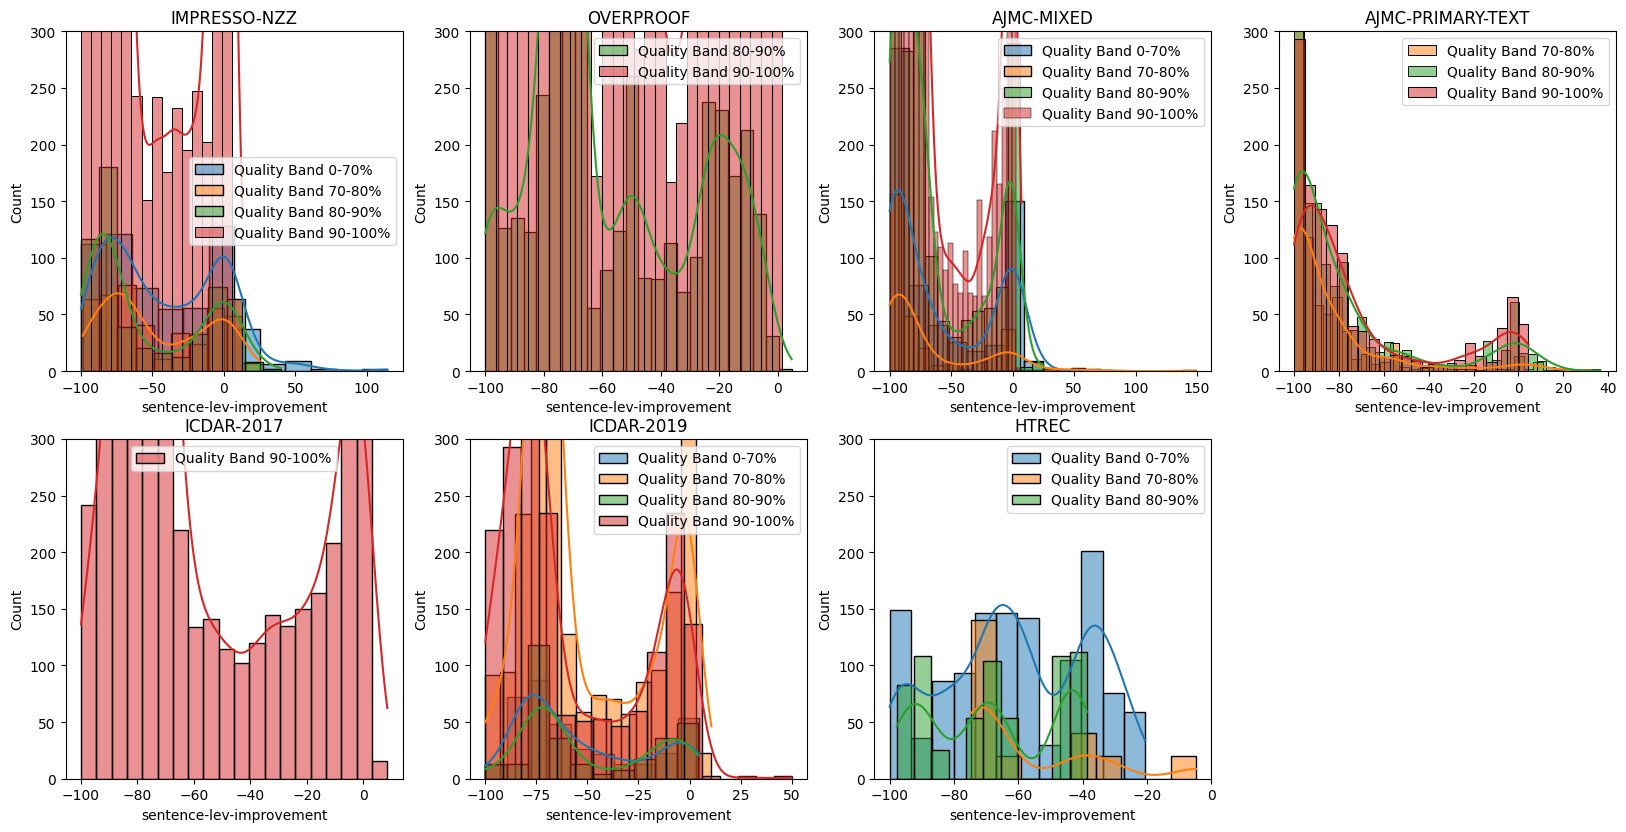

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

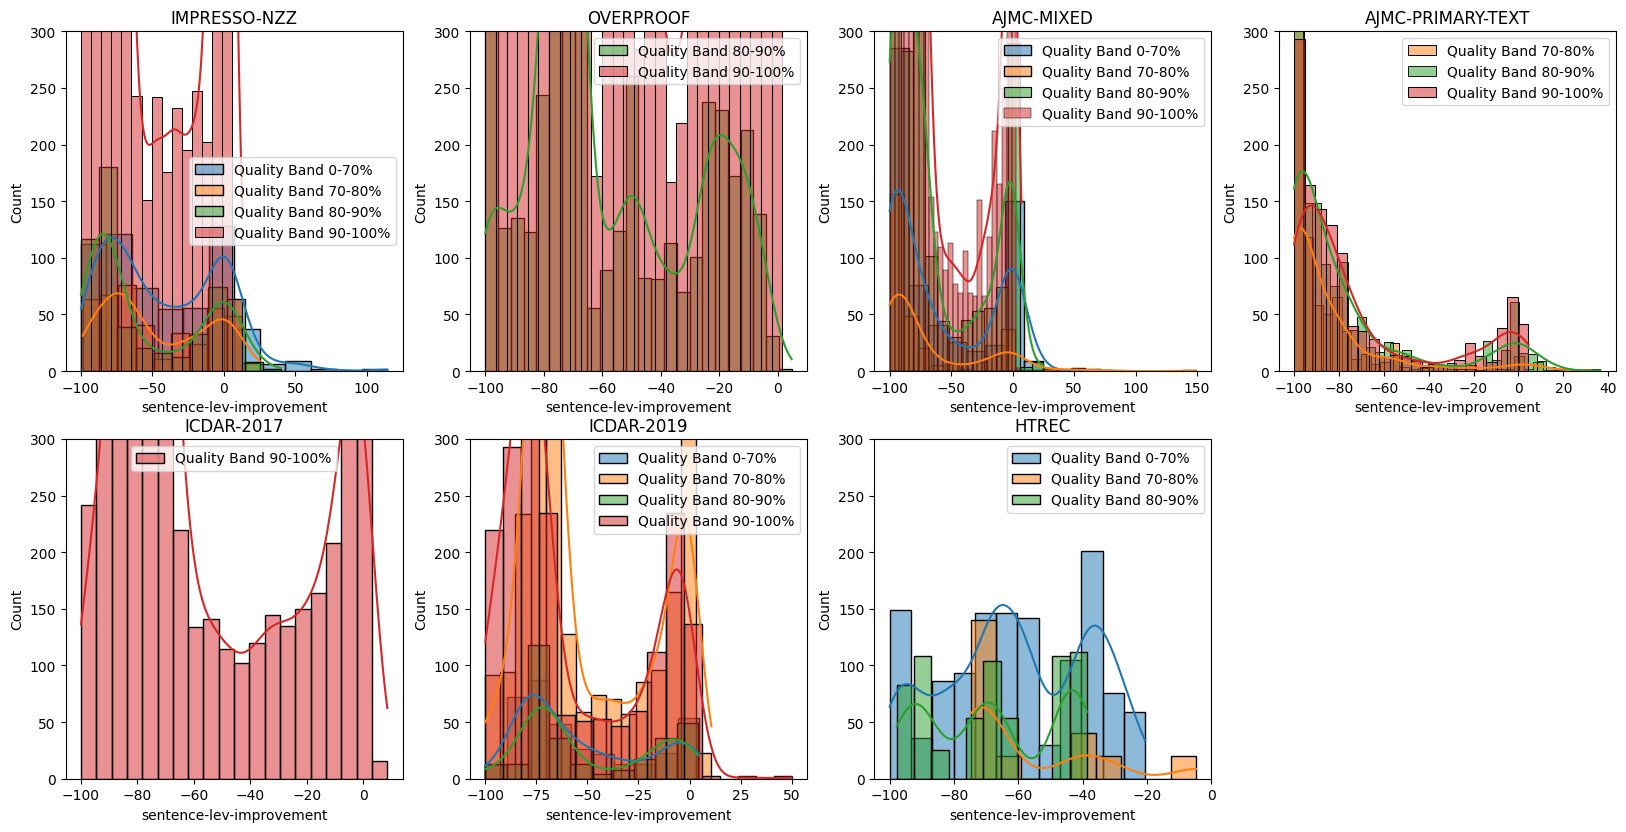

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Define the bins and labels for quality bands
bins = [0, 0.7, 0.8, 0.9, 1]
labels = ["0-70%", "70-80%", "80-90%", "90-100%"]

# Count the number of unique datasets
n_datasets = data.dataset_name.nunique()
dataset_names = ['impresso-nzz', 'overproof', 'ajmc-mixed', 
                 'ajmc-primary-text', 'icdar-2017', 'icdar-2019', 'htrec']

for error_rate in ['cer', 'wer']:
    # Create subplots
    fig, axs = plt.subplots(3, 4, figsize=(20, 15))

    # Flatten the axes for easy iteration
    axs = axs.flatten()

    for i, dataset in enumerate(dataset_names):
        dataset_data = data[data.dataset_name == dataset]

        # Compute the mean WER across line, sentence, and region levels
        dataset_data[f'Mean {error_rate.upper()}'] = dataset_data[[f'line-{error_rate}-ocr', 
                                                 f'sentence-{error_rate}-ocr', 
                                                 f'region-{error_rate}-ocr']].mean(axis=1)

        plt.figure(figsize=(10, 6))
        # Plot the distribution of WERs for each quality band
        for band in labels:
            band_df = dataset_data[dataset_data[f"{segment_type}-ocr-noise-group"] == band]

            _ = sns.histplot(band_df, x=f"sentence-lev-improvement", 
                             label=f"Quality Band {band}", kde=True, ax=axs[i])

        axs[i].set_ylim([0, 300])
        axs[i].set_title(f'{dataset.upper()}')
        axs[i].legend()

    # Remove empty subplots
    for i in range(len(data.dataset_name.unique()), len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.suptitle('Mean Word Error Rates across Datasets and Quality Bands', fontsize=20, y=1.02)
    plt.show()

## AJMC

In [ ]:
dataset = data[data.dataset_name == 'overproof']

dataset.head()

In [ ]:
# for idx, result in enumerate(results):
for segment_type in ['line', 'sentence', 'region']:
    print(segment_type, 'level', '*'*50)
    try:
        improved_texts = dataset[dataset['model'] == 'bigscience-bloom-560m'] 
        impooved_texts = improved_texts[improved_texts[f'{segment_type}-lev-improvement'] >= 0.7]
        #result[result[f'{segment_type}-lev-improvement'] >= 0.3]
        for _, improved_text in improved_texts.iterrows():
            print('Model:', improved_texts['model'].unique()[0])
            print('Dataset:', improved_texts['dataset_name'].unique()[0])
            print('Quality Band:', improved_text[f'{segment_type}-ocr-noise-group'])

            print('LEV ground-ocr', improved_text[f'{segment_type}-lev-ocr'], 
                  'LEV ground-pred', improved_text[f'{segment_type}-lev-pred'])
            print('LEV Improvement:', improved_text[f'{segment_type}-lev-improvement'])
            print('CER Improvement:', improved_text[f'{segment_type}-cer-improvement'])
            print('WER Improvement:', improved_text[f'{segment_type}-wer-improvement'])

            print('Ground:', improved_text[f'groundtruth.{segment_type}'][:50])
            print('OCR:', improved_text[f'ocr.{segment_type}'][:50])
            print('Pred:', improved_text[f'prediction.{segment_type}'])
            print('--'*50)
    except:
        continue
        

In [ ]:
prompt_order = ['prompt_basic_01', 'prompt_basic_02', 'prompt_complex_01']  # Replace these with your actual prompt names in the desired order

segment_levels = ['line', 'sentence', 'region']

for level in segment_levels:
    # Create a bar plot for CER improvement
    plt.figure(figsize=(12, 6))
    barplot = sns.barplot(data=dataset, x='model', y=f'{level}-lev-improvement', hue='prompt', hue_order=prompt_order)
    
    barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right')

    plt.title(f'{level.capitalize()}-level CER Improvement for ajmc by Model and Prompt')
    plt.show()

In [ ]:
data.columns

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

mean_metrics_df = data.groupby(['dataset_name', 'model', 'prompt', 'line-lev-improvement']).mean().reset_index()
print(mean_metrics_df.head())

plt.figure(figsize=(12, 6))
sns.barplot(data=mean_metrics_df, x='dataset_name', y='line-lev-improvement', hue='model')
plt.title('Line-level CER Improvement by Dataset and Model')
plt.show()


In [ ]:
for 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Set the colorblind color palette
sns.set_palette("colorblind")
plt.figure(figsize=(12, 6))

for model in data['model'].unique():
    data_per_model = data[data['model'] == model]
    for segment_type in ['line', 'sentence', 'region']:
        # Filter the data by dataset and segment type
        fig, ax = plt.subplots(figsize=(12, 6))

        # Create the box plot
        sns.boxplot(x=f'{segment_type}-ocr-noise-group', y=f'{segment_type}-lev-improvement', 
                    data=data_per_model, hue='dataset_name', palette='colorblind', ax=ax)

        # Set the plot title and axis labels
        plt.title(f'Levenshtein Distance Improvement for {segment_type.capitalize()} Segments ({model})')
        plt.xlabel('Quality Bands')
        plt.ylabel('Levenshtein Distance Improvement')
        
        plt.ylim((-0.5, 1.5))
        # Show the plot
        plt.show()



In [ ]:
for model in data['dataset_name'].unique():
    data_per_model = data[data['dataset_name'] == model]
    for segment_type in ['line', 'sentence', 'region']:
        # Filter the data by dataset and segment type
        fig, ax = plt.subplots(figsize=(12, 6))

        # Create the box plot
        sns.boxplot(x=f'{segment_type}-ocr-noise-group', y=f'{segment_type}-lev-improvement', 
                    data=data_per_model, hue='model', palette='colorblind', ax=ax)

        # Set the plot title and axis labels
        plt.title(f'Levenshtein Distance Improvement for {segment_type.capitalize()} Segments ({model})')
        plt.xlabel('Quality Bands')
        plt.ylabel('Levenshtein Distance Improvement')
        
        plt.ylim((-0.2, 1.0))
        # Show the plot
        plt.show()



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Set the colorblind color palette
sns.set_palette("colorblind")
plt.figure(figsize=(12, 6))

for result in results:
    
    dataset_name = result['dataset_name'].unique()[0]
    
    for segment_type in ['line', 'sentence', 'region']:
        
        #grouped_results = result.groupby([f"{segment_type}-ocr-noise-group", "dataset_name"]).size().reset_index(name="count")
        
        grouped_results = result.groupby([f"{segment_type}-ocr-noise-group", "dataset_name"])[f"{segment_type}-lev-improvement"].mean().reset_index()

        print(grouped_results.head())
        
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        _ = sns.lineplot(x=f"{segment_type}-ocr-noise-group", y=f'{segment_type}-lev-improvement', hue='dataset_name',
                 data=grouped_results, ax=ax, markers=True, linestyle='-', linewidth=2.5)


        # Set plot labels
        ax.set_xlabel(f"{dataset_name} Ground Truth {segment_type.capitalize()}")
        ax.set_ylabel(f"{dataset_name} {segment_type.capitalize()} Improvement")
        ax.set_title(f"{dataset_name} Levenshtein Improvement for {segment_type.capitalize()} OCR Examples")


        # Show the plot
        plt.show()

